## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from scipy import interp
import itertools

## Exploratory data analysis

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#observe the different feature type present in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

All the variables are non null

In [5]:
df.isnull().values.any()

False

Here we will observe the distribution of our classes

In [4]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

## Exploratory Data Analysis


In [5]:
normal_share

99.82725143693798

In [6]:
fraud_share

0.1727485630620034

As we can see the data is highly imbalanced with 99% of data belonging to the non fraud class and only .2% data belonging to fraud

Text(0, 0.5, 'Frequency')

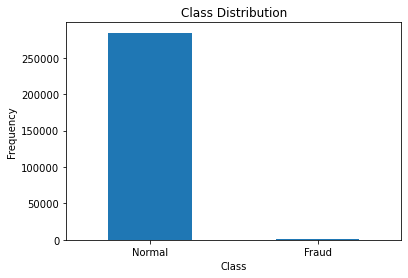

In [10]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations
LABELS = ["Normal", "Fraud"]
count_classes = pd.value_counts(df['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [7]:
## Creating the Fraud and the normal dataset 

fraud = df[df['Class']==1]

normal = df[df['Class']==0]

In [12]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [8]:
fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [14]:
#Let us analyze the "Amount" varible 
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [16]:
#Now let us analyze the "Amount" variable for normal transactions
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

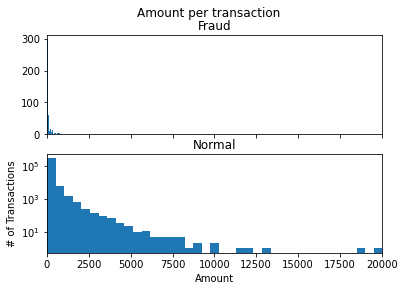

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount')
plt.ylabel('# of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

## As we can see that fraud amounts are very less compared to Normal it is concentrated and not uniform

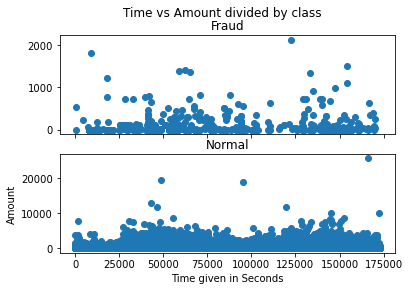

In [20]:
# Create a scatter plot to observe the distribution of classes with time
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time vs Amount divided by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time given in Seconds')
plt.ylabel('Amount')
plt.show()

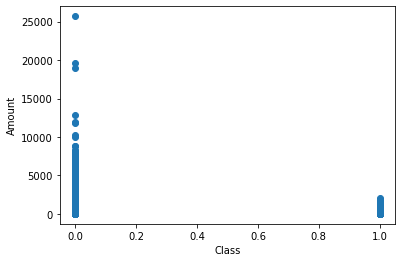

In [24]:
# Create a scatter plot to observe the distribution of classes with Amount

plt.scatter(df.Class, df.Amount)
plt.xlabel('Class')
plt.ylabel('Amount')
plt.show()

This shows the fraudulent transactions are highly concentrated at smaller values

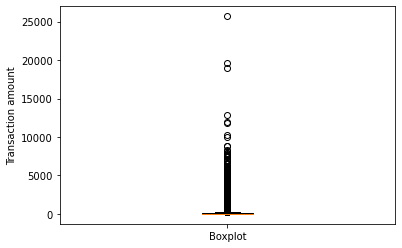

In [10]:
# Let us further analyze the variable "Amount"
plt.boxplot(df['Amount'], labels = ['Boxplot'])
plt.ylabel('Transaction amount')
plt.plot()

amount = df[['Amount']].sort_values(by='Amount')


In [11]:
q1, q3 = np.percentile(amount,[25,75])


In [12]:
q1,q3

(5.6, 77.16499999999999)

In [13]:
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)
print('# outliers below the lower bound: ', amount[amount['Amount'] < lower_bound].count()[0],
     ' ({:.4}%)'.format(amount[amount['Amount'] < lower_bound].count()[0] / amount['Amount'].count() * 100))
print('# outliers above the upper bound: ', amount[amount['Amount'] > upper_bound].count()[0],
      ' ({:.4}%)'.format(amount[amount['Amount'] > upper_bound].count()[0] / amount['Amount'].count() * 100))

# outliers below the lower bound:  0  (0.0%)
# outliers above the upper bound:  31904  (11.2%)


Interquartile Range (IQR) is an important find out as it can be used to find the the outliers. 
the difference between third quartile and the first quartile (IQR = Q3 -Q1). 
Outliers are the observations that are below (Q1 − 1.5x IQR) or 
boxplot lower whisker or above (Q3 + 1.5x IQR) or boxplot upper whisker.

Deleting this will be costly as it is 11.2% data

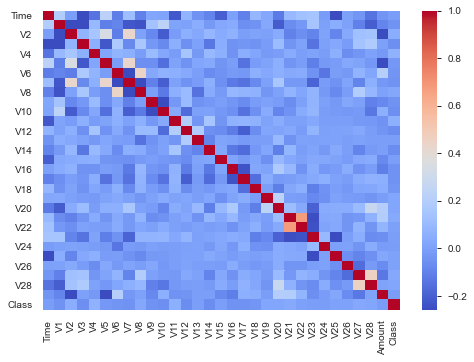

In [44]:
#Creating heatmaps using different correlation methods
heatmap = sns.heatmap(df.corr(method='spearman'),cmap='coolwarm',robust = True)

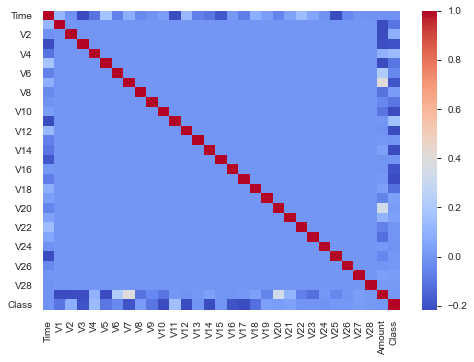

In [45]:
heatmap = sns.heatmap(df.corr(method='pearson'),cmap='coolwarm',robust = True)

Since all the variables are PCA transformed hence multicollinearity issue is not there any more in the data

In [14]:
# Drop unnecessary columns
# since variable time is not a very important variable we can drop the variable
df = df.drop(['Time'], axis=1)

In [15]:
df.shape

(284807, 30)

# Data Scaling

In [17]:
from sklearn.preprocessing import StandardScaler
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


# Class Imbalance
Once we load the data, we can easily observe the disparity between the fraudulent and non-fraudulent cases. In machine learning terms, this situation is known as ‘class imbalance’

### Splitting the data into train & test data

In [18]:
y= df['Class']
X = df.drop(columns=['Class'])

In [19]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


In [70]:
y.head(5)

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

In [21]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=42)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

## Model Building
- Build different models on the imbalanced dataset and see the result

In [22]:
import statsmodels.api as sm

In [23]:
# Building simple Logistic regression model without balancung the result
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Class   No. Observations:               199364
Model:                            GLM   Df Residuals:                   199334
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -716.43
Date:                Thu, 18 Jun 2020   Deviance:                       1432.9
Time:                        17:24:17   Pearson chi2:                 5.08e+05
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.0991      0.237    -38.450      0.000      -9.563      -8.635
V1             0.1012      0.054      1.883      0.060      -0.004       0.207
V2             0.0811      0.097      0.833      0.405      -0.110       0.272
V3             0.0128      0.056      0.228      0.820      -0.097       0.122
V4             0.9014      0.133      6.795      0.000       0.641       1.161
V5             0.1858      0.098      1.900      0.057      -0.006       0.378
V6            -0.0643      0.089     -0.720      0.471      -0.239       0.111
V7            -0.1126      0.101     -1.118      0.263      -0.310       0.085
V8            -0.1210      0.037     -3.285      0.001      -0.193      -0.049
V9            -0.1556      0.181     -0.859      0.390      -0.511       0.199
V10           -0.9871      0.146     -6.742      0.000      -1.274      -0.700
V11           -0.0388      0.093     -0.415      0.678      -0.222       0.144
V12            0.3049      0.141      2.165      0.030       0.029       0.581
V13           -0.4842      0.106     -4.570      0.000      -0.692      -0.277
V14           -0.5396      0.088     -6.138      0.000      -0.712      -0.367
V15           -0.0125      0.111     -0.113      0.910      -0.229       0.204
V16           -0.3059      0.191     -1.604      0.109      -0.680       0.068
V17           -0.1040      0.108     -0.966      0.334      -0.315       0.107
V18            0.0932      0.198      0.471      0.638      -0.295       0.481
V19           -0.0151      0.136     -0.111      0.912      -0.282       0.252
V20           -0.5348      0.099     -5.377      0.000      -0.730      -0.340
V21            0.3996      0.079      5.027      0.000       0.244       0.555
V22            0.6132      0.179      3.430      0.001       0.263       0.964
V23           -0.0953      0.073     -1.301      0.193      -0.239       0.048
V24            0.1326      0.182      0.730      0.466      -0.223       0.489
V25           -0.0096      0.164     -0.059      0.953      -0.330       0.311
V26            0.3069      0.260      1.180      0.238      -0.203       0.817
V27           -0.9113      0.134     -6.821      0.000      -1.173      -0.649
V28           -0.2809      0.114     -2.461      0.014      -0.505      -0.057
Amount         0.2860      0.132      2.160      0.031       0.026       0.546
==============================================================================
"""

###  Feature Selection Using RFE

In [24]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [25]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

C:\Users\haris\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [26]:
rfe.support_

array([ True, False, False,  True, False, False,  True, False,  True,
        True, False,  True,  True,  True, False,  True, False, False,
       False,  True,  True,  True, False, False, False, False,  True,
        True,  True])

In [27]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('V1', True, 1),
 ('V2', False, 9),
 ('V3', False, 13),
 ('V4', True, 1),
 ('V5', False, 3),
 ('V6', False, 10),
 ('V7', True, 1),
 ('V8', False, 5),
 ('V9', True, 1),
 ('V10', True, 1),
 ('V11', False, 11),
 ('V12', True, 1),
 ('V13', True, 1),
 ('V14', True, 1),
 ('V15', False, 12),
 ('V16', True, 1),
 ('V17', False, 8),
 ('V18', False, 7),
 ('V19', False, 15),
 ('V20', True, 1),
 ('V21', True, 1),
 ('V22', True, 1),
 ('V23', False, 6),
 ('V24', False, 2),
 ('V25', False, 14),
 ('V26', False, 4),
 ('V27', True, 1),
 ('V28', True, 1),
 ('Amount', True, 1)]

In [28]:
col = X_train.columns[rfe.support_]

In [29]:
X_train.columns[~rfe.support_]

Index(['V2', 'V3', 'V5', 'V6', 'V8', 'V11', 'V15', 'V17', 'V18', 'V19', 'V23',
       'V24', 'V25', 'V26'],
      dtype='object')

In [30]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Class   No. Observations:               199364
Model:                            GLM   Df Residuals:                   199348
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -734.42
Date:                Thu, 18 Jun 2020   Deviance:                       1468.8
Time:                        17:25:59   Pearson chi2:                 4.30e+05
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9361      0.190    -46.983      0.000      -9.309      -8.563
V1             0.2155      0.047      4.580      0.000       0.123       0.308
V4             0.7885      0.087      9.091      0.000       0.618       0.958
V7            -0.1821      0.081     -2.261      0.024      -0.340      -0.024
V9            -0.2867      0.112     -2.562      0.010      -0.506      -0.067
V10           -0.8087      0.108     -7.516      0.000      -1.020      -0.598
V12            0.2280      0.093      2.452      0.014       0.046       0.410
V13           -0.4859      0.102     -4.761      0.000      -0.686      -0.286
V14           -0.6206      0.066     -9.375      0.000      -0.750      -0.491
V16           -0.2317      0.086     -2.702      0.007      -0.400      -0.064
V20           -0.5037      0.077     -6.512      0.000      -0.655      -0.352
V21            0.4954      0.080      6.193      0.000       0.339       0.652
V22            0.6886      0.155      4.436      0.000       0.384       0.993
V27           -0.9981      0.126     -7.908      0.000      -1.245      -0.751
V28           -0.1867      0.119     -1.565      0.118      -0.421       0.047
Amount         0.2648      0.095      2.782      0.005       0.078       0.451
==============================================================================
"""

##### Assessing the model with StatsModels

In [31]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [32]:
y_train_pred[:10]

array([3.75279562e-05, 4.96492246e-04, 6.97428512e-05, 2.69386138e-05,
       6.32129103e-05, 2.93240268e-05, 3.38797979e-04, 3.29669590e-04,
       2.19123374e-03, 4.94185223e-05])

In [33]:
y_train_pred_final = pd.DataFrame({'Class':y_train.values, 'Class_Prob':y_train_pred})


In [34]:
y_train_pred_final.head()

,Class,Class_Prob
0,0,0.000038
1,0,0.000496
2,0,0.000070
3,0,0.000027
4,0,0.000063


In [35]:
y_train_pred_final['predicted'] = y_train_pred_final.Class_Prob.map(lambda x: 0 if x < 0.01 else 1)


In [36]:
y_train_pred_final.tail()

,Class,Class_Prob,predicted
199359,0,0.000054,0
199360,0,0.000382,0
199361,0,0.000367,0
199362,0,0.000792,0
199363,0,0.000265,0


In [37]:
from sklearn import metrics

In [38]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Class, y_train_pred_final.predicted )
print(confusion)

[[198548    472]
 [    43    301]]


In [39]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Class, y_train_pred_final.predicted))

0.9974167853775004


#Though the accuracy is high the False Negative and True positive is high which shows the model needs some tuning

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- Random Undersampling
- Adasyn


We will try three techniques for resampling and they are:¶
random undersampling, random oversampling and Synthetic Minority Over-sampling (SMOTE), Adaptive synthesis(ADAsyn).

As observed, the data shows a high class imbalance. Over 2,00,000 cases are 0, but hardly 500 cases are  1. Any model would not work well. Only when the classes are balanced that is when there is equal representation of each of the classes model perforsm well. However, in this case, no matter which model you build, the underlying algorithm will learn more about the non-fraudulent cases rather than the fraudulent ones. Therefore, the loss function optimisation will be heavily biased to the former type of data. This is known as the ‘minority class problem’.

In [40]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
249927,-0.012102,0.707332,0.163334,-0.756498,0.590999,-0.653429,0.844608,-0.001672,-0.184399,-0.222719,...,-0.038329,-0.231385,-0.572415,0.042660,-0.360882,-0.494703,0.142657,0.235922,0.083758,-0.324723
214082,1.776151,-0.184642,-2.204096,1.191668,0.614461,-1.016525,0.919254,-0.387465,-0.318277,0.517022,...,-0.030437,0.281190,0.530070,-0.232262,-0.342096,0.492355,-0.427682,-0.075228,-0.056755,0.246484
106005,-1.083391,-4.440527,-1.399530,0.469764,-2.076458,-0.766137,1.601441,-0.709176,-1.288745,0.086419,...,2.189260,0.346463,-1.432833,-1.097063,0.505926,-0.140185,0.870190,-0.316982,0.227833,4.854238
58619,-0.518847,1.025087,-0.614624,-0.780959,2.474666,3.335055,0.046111,0.794249,-0.322448,0.128383,...,0.225957,-0.193099,-0.708348,0.145672,0.944217,-0.788017,0.039995,0.010804,0.254309,-0.335278
191638,-0.640421,0.212171,0.283341,-1.786916,2.616127,4.024863,-0.198897,0.937087,0.474428,-0.283699,...,0.154309,0.167939,0.759218,-0.321412,0.767971,-0.084221,0.612936,0.074029,-0.033344,-0.335278


# Random Undersampling

In this method, you have the choice of selecting fewer data points from the majority class for your model-building process. In case you have only 500 data points in the minority class, you will also have to take 500 data points from the majority class; this will make the classes somewhat balanced. However, in practice, this method is not effective because you will lose over 99% of the original data.

In [44]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42, replacement=False)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [45]:
X_rus.shape,y_rus.shape

((688, 29), (688,))

As we can see the data is balanced now however we loose 98% of information in this procedure 

In [47]:
y_rus.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

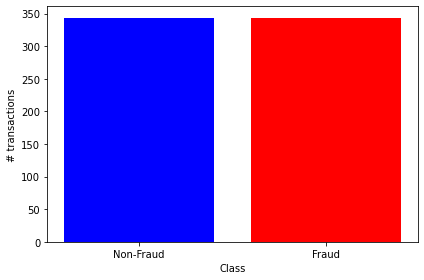

In [49]:
plt.bar(['Non-Fraud','Fraud'], [Counter(y_rus)[0], Counter(y_rus)[1]], color=['b','r'])
plt.xlabel('Class')
plt.ylabel('# transactions')

plt.tight_layout()
plt.show()

In [52]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_rus)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 344, 1: 344})


# Random oversampling

Random oversampling involves randomly minority points from the minority to group to match the length of the majority class.
The process is entirely randowm it takes few rows from the minority class and adds up

In [53]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=48)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

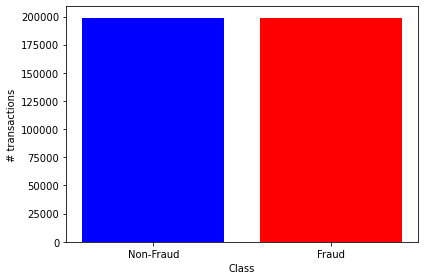

In [54]:
plt.bar(['Non-Fraud','Fraud'], [Counter(y_ros)[0], Counter(y_ros)[1]], color=['b','r'])
plt.xlabel('Class')
plt.ylabel('# transactions')

plt.tight_layout()
plt.show()

In [55]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_ros)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 199020, 1: 199020})


# Synthetic Minority Over-Sampling Technique (SMOTE)

In this process, you can generate new data points, which lie vectorially between two data points that belong to the minority class. 
These data points are randomly chosen and then assigned to the minority class. 
This method uses K-nearest neighbours to create random synthetic samples. 

![title](SMOTE.png)

In [56]:
smote = SMOTE(sampling_strategy='auto', random_state=48)
X_smote, y_smote = smote.fit_resample(X_train, y_train)


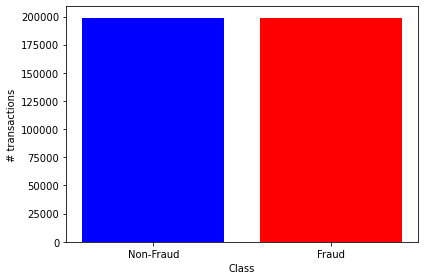

In [57]:
plt.bar(['Non-Fraud','Fraud'], [Counter(y_smote)[0], Counter(y_smote)[1]], color=['b','r'])
plt.xlabel('Class')
plt.ylabel('# transactions')

plt.tight_layout()
plt.show()

In [58]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_smote)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({0: 199020, 1: 199020})


# ADASyn(Adaptive synthesis)

This is similar to SMOTE, with a minor change in the generation of synthetic sample points for minority data points. 
For a particular data point, the number of synthetic samples that it will add will have a density distribution, whereas, 
for SMOTE, the distribution will be uniform. 
The aim here is to create synthetic data for minority examples that are harder to learn, rather than the easier ones.

In [59]:
from imblearn.over_sampling import ADASYN

In [63]:
ads = ADASYN(sampling_strategy='auto', random_state=48)
X_ads, y_ads = ads.fit_resample(X_train, y_train)

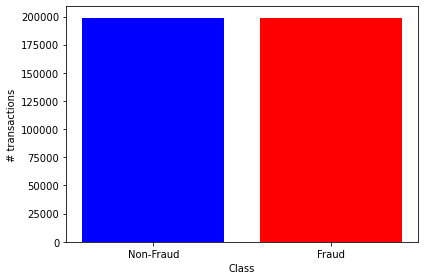

In [64]:
plt.bar(['Non-Fraud','Fraud'], [Counter(y_ads)[0], Counter(y_ads)[1]], color=['b','r'])
plt.xlabel('Class')
plt.ylabel('# transactions')

plt.tight_layout()
plt.show()

In [65]:
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_ads)))

Original dataset shape Counter({0: 284315, 1: 492})
Resampled dataset shape Counter({1: 199035, 0: 199020})


We will create 2d plot to visualize the transformed data 

In [73]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#8c564b', '#FF7F0E']
    markers = ['v', '^']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [74]:
pca = PCA(n_components=2)
X_ros_pca = pca.fit_transform(X_ros)
X_smote_pca = pca.fit_transform(X_smote)
X_ads_pca = pca.fit_transform(X_ads)
X_rus_pca = pca.fit_transform(X_rus)

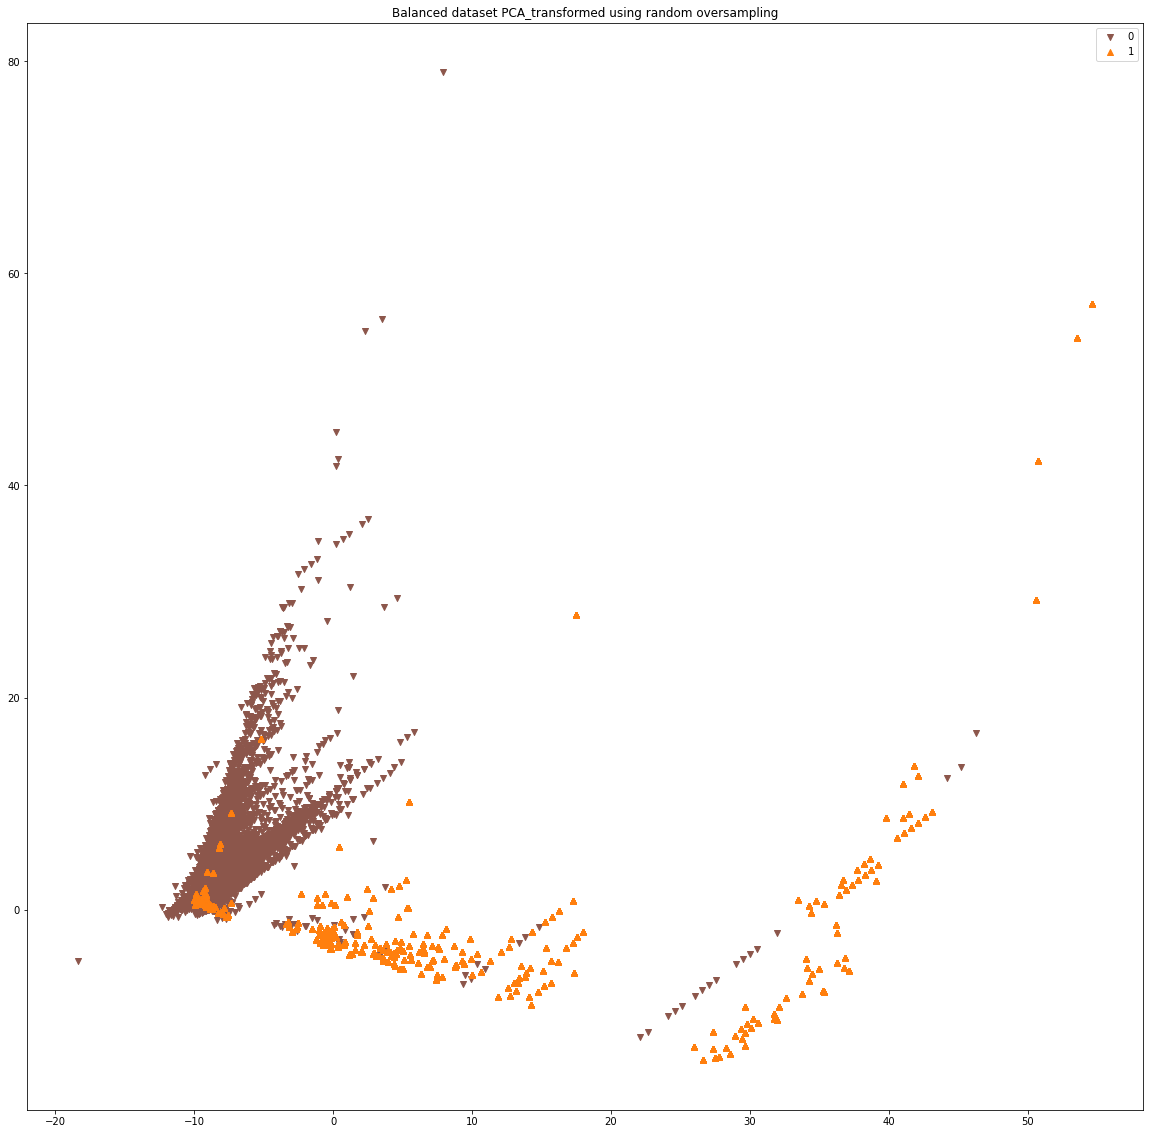

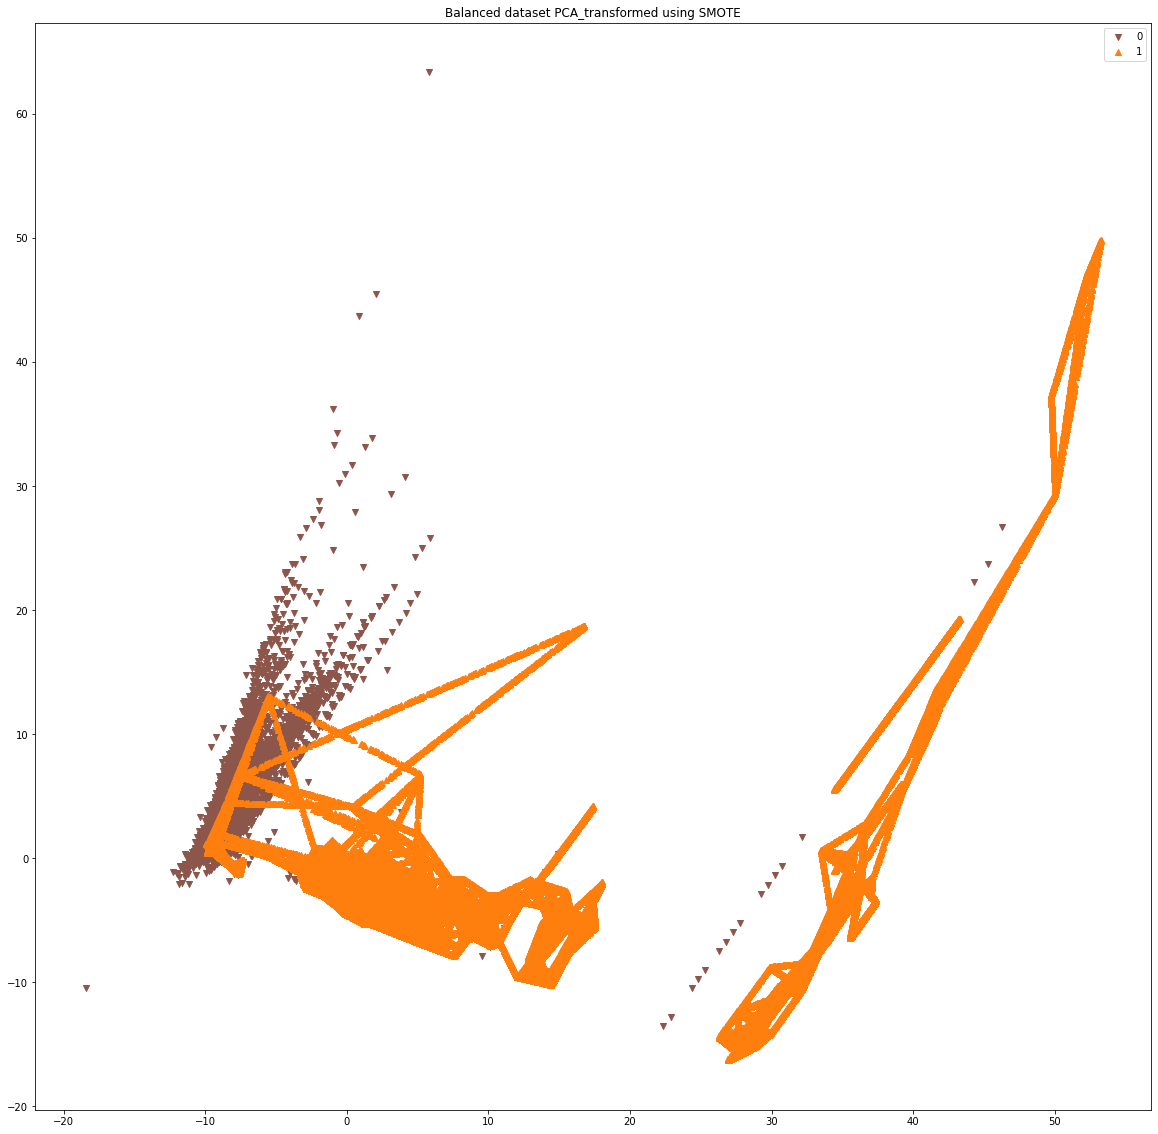

In [75]:
plot_2d_space(X_ros_pca, y_ros, 'Balanced dataset PCA_transformed using random oversampling')
plot_2d_space(X_smote_pca, y_smote, 'Balanced dataset PCA_transformed using SMOTE')

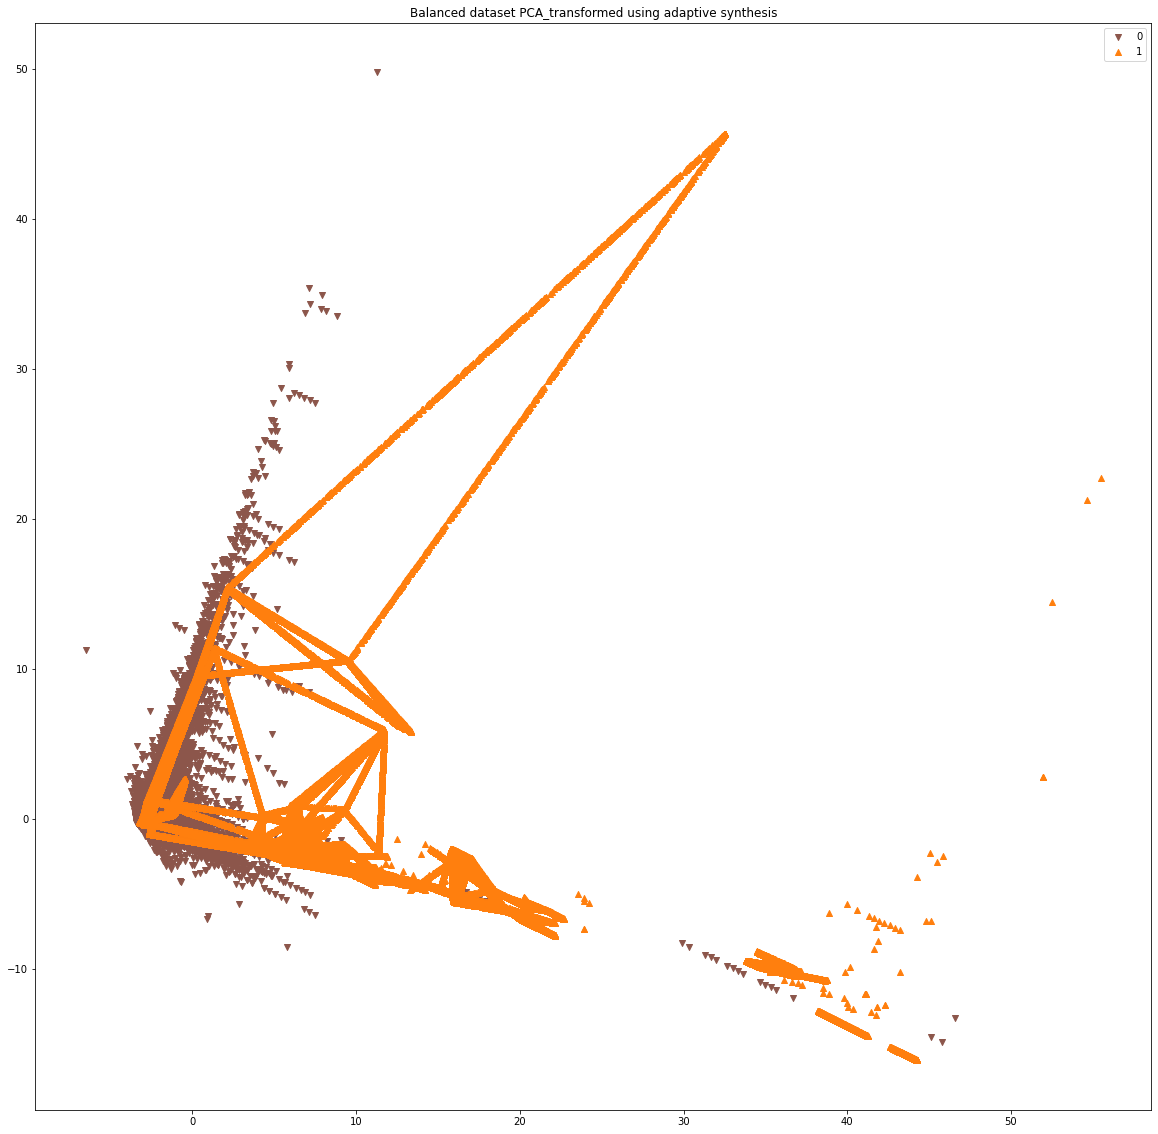

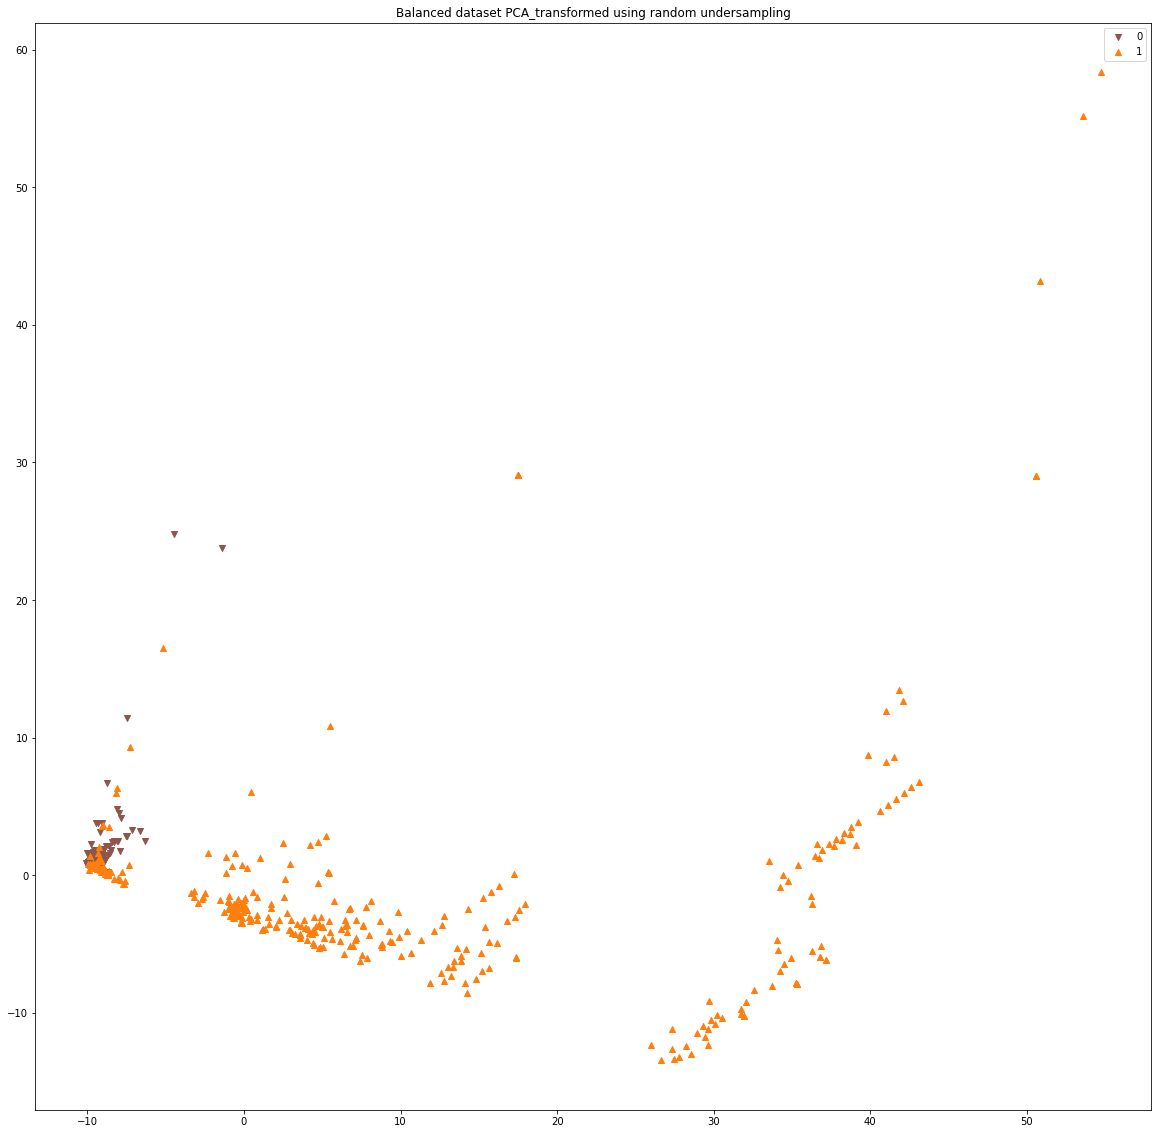

In [76]:
plot_2d_space(X_ads_pca, y_ads, 'Balanced dataset PCA_transformed using adaptive synthesis')
plot_2d_space(X_rus_pca, y_rus, 'Balanced dataset PCA_transformed using random undersampling')

# Logistic regression on random undersampling data

In [79]:
lr = LogisticRegression(max_iter=200, random_state=0, n_jobs = -1)
lr.fit(X_rus, y_rus)

LogisticRegression(max_iter=200, n_jobs=-1, random_state=0)

In [80]:
lr_predict = lr.predict(X_test)


In [81]:
lr_predict

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# Prediction scores

Accuracy: 97.5844%
Recall: 87.8378%
ROC AUC: 92.7196%


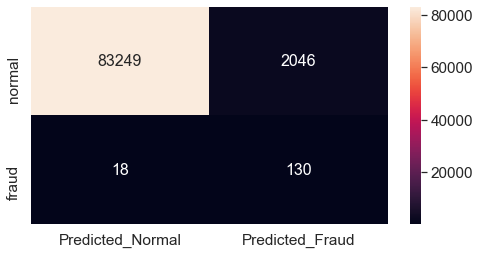

In [84]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,roc_auc_score
from matplotlib import pyplot

lr_accuracy = accuracy_score(y_test, lr_predict)
lr_recall = recall_score(y_test, lr_predict)
lr_cm = confusion_matrix(y_test, lr_predict)
lr_auc = roc_auc_score(y_test, lr_predict)

print("Accuracy: {:.4%}".format(lr_accuracy))
print("Recall: {:.4%}".format(lr_recall))
print("ROC AUC: {:.4%}".format(lr_auc))

lr_cm = pd.DataFrame(lr_cm, ['normal','fraud'],['Predicted_Normal','Predicted_Fraud'])
pyplot.figure(figsize = (8,4))
sns.set(font_scale=1.4)
sns.heatmap(lr_cm, annot=True,annot_kws={"size": 16},fmt='g')

# Logistic regression on random oversampling data

In [85]:
lr = LogisticRegression(max_iter=200, random_state=0, n_jobs = -1)
lr.fit(X_ros, y_ros)

LogisticRegression(max_iter=200, n_jobs=-1, random_state=0)

In [87]:
lr_predict_ros = lr.predict(X_test)


Accuracy: 97.7997%
Recall: 87.1622%
ROC AUC: 92.4902%


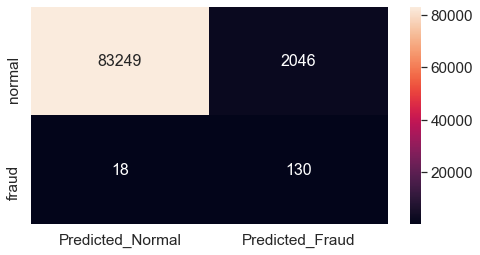

In [88]:
lr_accuracy_ros = accuracy_score(y_test, lr_predict_ros)
lr_recall_ros = recall_score(y_test, lr_predict_ros)
lr_cm_ros = confusion_matrix(y_test, lr_predict_ros)
lr_auc_ros = roc_auc_score(y_test, lr_predict_ros)

print("Accuracy: {:.4%}".format(lr_accuracy_ros))
print("Recall: {:.4%}".format(lr_recall_ros))
print("ROC AUC: {:.4%}".format(lr_auc_ros))

lr_cm = pd.DataFrame(lr_cm, ['normal','fraud'],['Predicted_Normal','Predicted_Fraud'])
pyplot.figure(figsize = (8,4))
sns.set(font_scale=1.4)
sns.heatmap(lr_cm, annot=True,annot_kws={"size": 16},fmt='g')

# Logistic regression on SMOTE oversampling data


In [89]:
lr = LogisticRegression(max_iter=200, random_state=0, n_jobs = -1)
lr.fit(X_smote, y_smote)

LogisticRegression(max_iter=200, n_jobs=-1, random_state=0)

In [90]:
lr_predict_smote = lr.predict(X_test)


Accuracy: 97.6780%
Recall: 87.8378%
ROC AUC: 92.7664%


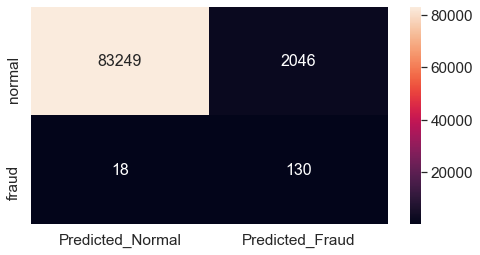

In [91]:
lr_accuracy_smote = accuracy_score(y_test, lr_predict_smote)
lr_recall_smote = recall_score(y_test, lr_predict_smote)
lr_cm_smote = confusion_matrix(y_test, lr_predict_smote)
lr_auc_smote = roc_auc_score(y_test, lr_predict_smote)

print("Accuracy: {:.4%}".format(lr_accuracy_smote))
print("Recall: {:.4%}".format(lr_recall_smote))
print("ROC AUC: {:.4%}".format(lr_auc_smote))

lr_cm = pd.DataFrame(lr_cm, ['normal','fraud'],['Predicted_Normal','Predicted_Fraud'])
pyplot.figure(figsize = (8,4))
sns.set(font_scale=1.4)
sns.heatmap(lr_cm, annot=True,annot_kws={"size": 16},fmt='g')

# Logistic regression on Adasyn oversampling data


In [92]:
lr = LogisticRegression(max_iter=200, random_state=0, n_jobs = -1)
lr.fit(X_ads, y_ads)

LogisticRegression(max_iter=200, n_jobs=-1, random_state=0)

In [93]:
lr_predict_ads = lr.predict(X_test)


Accuracy: 92.4640%
Recall: 89.8649%
ROC AUC: 91.1667%


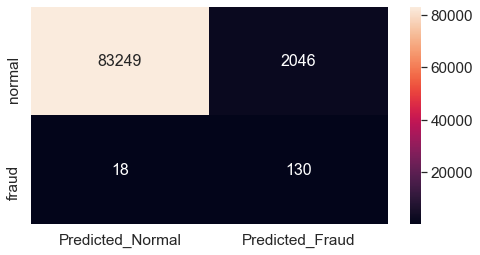

In [94]:
lr_accuracy_ads = accuracy_score(y_test, lr_predict_ads)
lr_recall_ads = recall_score(y_test, lr_predict_ads)
lr_cm_ads = confusion_matrix(y_test, lr_predict_ads)
lr_auc_ads = roc_auc_score(y_test, lr_predict_ads)

print("Accuracy: {:.4%}".format(lr_accuracy_ads))
print("Recall: {:.4%}".format(lr_recall_ads))
print("ROC AUC: {:.4%}".format(lr_auc_ads))

lr_cm = pd.DataFrame(lr_cm, ['normal','fraud'],['Predicted_Normal','Predicted_Fraud'])
pyplot.figure(figsize = (8,4))
sns.set(font_scale=1.4)
sns.heatmap(lr_cm, annot=True,annot_kws={"size": 16},fmt='g')

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

### Similarly explore other algorithms on balanced dataset by building models like:
- KNN
- Random Forest
- XGBoost

Apart from logistic regression let us explore other option 
since it a classification problem logistic regression is prefferred over all other 

In [96]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

Using SMOTE we got: Accuracy: 97.6780%
Recall: 87.8378%
ROC AUC: 92.7664%
Also we are not loosing any information hence we will use this technique further

# Random Forest

Let's first fit a random forest model with default hyperparameters.

one of the most popular algorithms in machine learning. Random forests use a technique known as bagging, which is an ensemble method. So before diving into random forests, let's first understand ensembles.

In [97]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [98]:
# fit
rfc.fit(X_smote,y_smote)

RandomForestClassifier()

In [99]:
# Making predictions
predictions = rfc.predict(X_test)

In [100]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [101]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.78      0.82       148

    accuracy                           1.00     85443
   macro avg       0.93      0.89      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [102]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))

[[85276    19]
 [   32   116]]


In [103]:
print(accuracy_score(y_test,predictions))

0.999403110845827


So far so good, let's now look at the list of hyperparameters which we can tune to improve model performance.

In [105]:
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

In [106]:
# Fit on training data
model.fit(X_smote, y_smote)

RandomForestClassifier(max_features='sqrt')

In [107]:
# Making predictions
predictions = model.predict(X_test)

In [108]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.78      0.83       148

    accuracy                           1.00     85443
   macro avg       0.94      0.89      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [109]:
print(accuracy_score(y_test,predictions))

0.9994382219725431


In [110]:
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]

In [111]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)

In [112]:
roc_value

0.9615694655908033

In [113]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [114]:
fpr, tpr, thresholds = metrics.roc_curve( y_test, rf_probs, drop_intermediate = False )

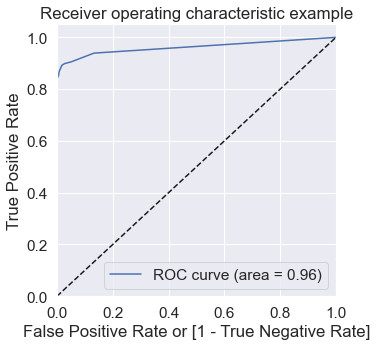

In [115]:
draw_roc(y_test, rf_probs)

# Finding the best k in KNN

In [120]:
import xgboost as xgb


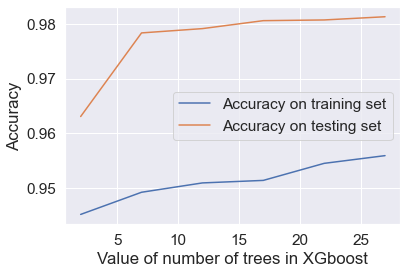

In [121]:

from xgboost import XGBClassifier
tree_range = range(2, 30, 5)
score1=[]
score2=[]
for tree in tree_range:
    xgb=XGBClassifier(n_estimators=tree)
    xgb.fit(X_smote,y_smote)
    score1.append(xgb.score(X_smote,y_smote))
    score2.append(xgb.score(X_test,y_test))
    
%matplotlib inline
plt.plot(tree_range,score1,label= 'Accuracy on training set')
plt.plot(tree_range,score2,label= 'Accuracy on testing set')
plt.xlabel('Value of number of trees in XGboost')
plt.ylabel('Accuracy')
plt.legend()

As we can see accuracy is increasing for the test and stabilizes at one point

In [124]:
xgb=XGBClassifier(n_estimators=18)
xgb.fit(X_smote,y_smote)
print('Accuracy of XGB on the testing dataset is :{:.3f}'.format(xgb.score(X_test,y_test)))

Accuracy of XGB on the testing dataset is :0.981


In [125]:
# we got a 98% score using xgboost

In [131]:
print(xgb.feature_importances_)

[0.02385276 0.         0.00745593 0.05018785 0.         0.
 0.00152174 0.036133   0.         0.08121298 0.0229368  0.03396264
 0.00294795 0.64080507 0.02397992 0.00067698 0.03092437 0.03999018
 0.         0.         0.         0.00341177 0.         0.
 0.         0.         0.         0.         0.        ]


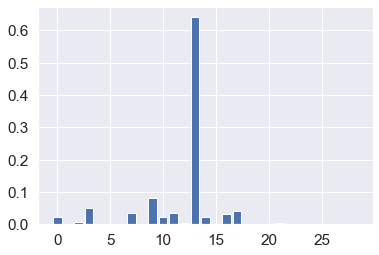

In [132]:
pyplot.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
pyplot.show()

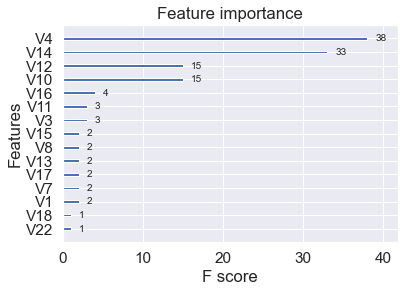

In [135]:
from xgboost import plot_importance
plot_importance(xgb)
pyplot.show()

## 3. Cross-Validation: 

The following figure illustrates k-fold cross-validation with k=4. There are some other schemes to divide the training set, we'll look at them briefly later.

#<img src="K-fold-cross-validation-method.png" title="K-Fold Cross Validation" />

It is a statistical technique which enables us to make extremely efficient use of available data
It divides the data into several pieces, or 'folds', and uses each piece as test data one at a time

In [137]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [138]:
xgb=XGBClassifier(n_estimators=18)
scores = cross_val_score(xgb, X_smote, y_smote, scoring='r2', cv=5)
scores 

array([0.80790875, 0.81298362, 0.80635112, 0.81006934, 0.81469199])

In [139]:
# the other way of doing the same thing (more explicit)

# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores_1 = cross_val_score(xgb, X_smote, y_smote, scoring='r2', cv=folds)
scores_1   

array([0.8041402 , 0.81201862, 0.81222989, 0.81725355, 0.80936293])

### 4.2 Hyperparameter Tuning Using Grid Search Cross-Validation

A common use of cross-validation is for tuning hyperparameters of a model. The most common technique is what is called **grid search** cross-validation.


<img src="Grid_search.png"/>

In [142]:
# number of features in X_train
len(X_smote.columns)

29

In [144]:
## The cross validation code did not work it took more than 20 hrs and still didnt get the output

# Conclusion

We used several methods to predict the default the best result we got by using XGboost on data which was sampled using SMOTE
the Accuracy of XGB on the testing dataset is :0.981. Also the important features are:V4,V14,V12,V16,V11.
Also by performing logistic regression we got a good score of Accuracy: 97.6780%
Recall: 87.8378%
ROC AUC: 92.7664%
For classification model logistic regression can be used as the benchmark model.